In [1]:
import sys
sys_path = 'D:/Research_CAE/MyTinyCUDANN/tiny-cuda-nn/main'
sys.path.append(sys_path)
from my_tiny_cuda import my_MLP
from tools import random_points_1D,collocation_points_1D, ShiftedLegendrePolynomial2D
from gradient import grad1, grad2
import torch
import numpy as np
device = 'cuda'

In [2]:
def generate_grid_points(resolution, field_min = 0, field_max = 1):
    x1_list = np.linspace(field_min, field_max, resolution)
    x2_list = np.linspace(field_min, field_max, resolution)
    X1,X2 = np.meshgrid(x1_list,x2_list)
    X_field = torch.tensor(np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),
    axis = 1)).float().to(device)
    return X_field

def sample_all_boundary(batch_size_BC,field_min = 0, field_max = 1):
    n00 = torch.tensor([field_min,field_min])
    n01 = torch.tensor([field_min,field_max])
    n10 = torch.tensor([field_max,field_min])
    n11 = torch.tensor([field_max,field_max])
    X_bot = random_points_1D(int(batch_size_BC),n00,n10)
    X_left = random_points_1D(int(batch_size_BC),n00,n01)
    X_right = random_points_1D(int(batch_size_BC),n10,n11)
    X_top = random_points_1D(int(batch_size_BC),n01,n11)
    X_boundaries = torch.cat((X_bot,X_left,X_top,X_right), dim = 0)
    return X_boundaries

class Heat_equation(torch.nn.Module):
    def __init__(self,k = 1, L = 1):
        super().__init__()
        self.k = k
        self.L = L
        self.tau = 1e-4
    def strong_form(self,X,grad_result):
        du_dt,d2u_dx2 = grad_result["du_dx"],grad_result["d2u_dy2"]
        result = du_dt - self.k*d2u_dx2
        return result
    def weak_form(self,X,grad_result, grad_result_v):
        # The shape of grad_result is (batch_size)
        # The shape of grad_result_v is (batch_size,max_order^2)
        du_dt,du_dx = grad_result["du_dx"].unsqueeze(1),grad_result["du_dy"].unsqueeze(1)
        v, dv_dx = grad_result_v["u"],grad_result_v["du_dy"]
        result = du_dt* v + du_dx * dv_dx
        return result
    def BC_function(self,X):
        # return torch.sin(X[:,0]*torch.pi)*torch.sin(X[:,1]*torch.pi)
        return self.real_solution(X)
    def real_solution(self,X):
        return torch.exp(-self.k*(torch.pi/self.L)**2*X[:,0])*torch.sin(X[:,1]*torch.pi/self.L)

In [3]:
model = my_MLP(activation = torch.nn.Tanh(), n_input_dims = 2,
            n_hidden = 4, width = 64,
            spectral_norm = False,dtype = torch.float32).to(device)
equation = Heat_equation()

In [4]:
max_order = 50
boundary_sample_points = sample_all_boundary(1000)
f_boundary = equation.BC_function(boundary_sample_points).to(device)
resolution = 100
grid_points = generate_grid_points(resolution)
test_function = ShiftedLegendrePolynomial2D(max_order).to(device)
v = test_function(grid_points[:,0],grid_points[:,1])
dv_dx, dv_dy = test_function.derivatives(grid_points[:,0],grid_points[:,1])
grad_result_v = {"u":v,"du_dx":dv_dx,"du_dy":dv_dy}
# optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
optimizer = torch.optim.LBFGS(model.parameters(),lr = 0.5,
                            max_iter = 100,line_search_fn="strong_wolfe")
MSELoss = torch.nn.MSELoss().to(device)

In [5]:
lam = 10.0
n_step = 300
n_step_output = 10
model.train()
diff_info = grad2(model,grid_points.shape[0])
diff_info.to_device(device)
for i in range(n_step):
    def closure():
        global bc_loss, inner_loss
        optimizer.zero_grad()
        bc_loss = MSELoss(model(boundary_sample_points),f_boundary)
        grad_result = diff_info.forward(grid_points)
        PDE_residual = equation.weak_form(grid_points,grad_result,grad_result_v)
        inner_loss = (PDE_residual**2).mean()
        loss = inner_loss + lam* bc_loss
        loss.backward()
        return loss
    optimizer.step(closure)
    if i % n_step_output == 0:
        model.eval()
        with torch.no_grad():
            u_error = MSELoss(model(grid_points),equation.real_solution(grid_points))
        print('Iter:',i,'inner_loss:',inner_loss.item(),"\n",
        'bc_loss:',bc_loss.item(),'u_L2:',u_error.item(),)
        model.train()

Iter: 0 inner_loss: 0.012950791977345943 
 bc_loss: 0.04739299416542053 u_L2: 0.012563335709273815
Iter: 10 inner_loss: 0.046771030873060226 
 bc_loss: 0.02766994945704937 u_L2: 0.006715546362102032
Iter: 20 inner_loss: 0.054017990827560425 
 bc_loss: 0.02641715668141842 u_L2: 0.006665507331490517
Iter: 30 inner_loss: 0.05305377021431923 
 bc_loss: 0.026451079174876213 u_L2: 0.006889938376843929
Iter: 40 inner_loss: 0.05305377021431923 
 bc_loss: 0.026451079174876213 u_L2: 0.006889938376843929
Iter: 50 inner_loss: 0.05305377021431923 
 bc_loss: 0.026451079174876213 u_L2: 0.006889938376843929
Iter: 60 inner_loss: 0.05305377021431923 
 bc_loss: 0.026451079174876213 u_L2: 0.006889938376843929
Iter: 70 inner_loss: 0.05305377021431923 
 bc_loss: 0.026451079174876213 u_L2: 0.006889938376843929
Iter: 80 inner_loss: 0.05305377021431923 
 bc_loss: 0.026451079174876213 u_L2: 0.006889938376843929
Iter: 90 inner_loss: 0.05305377021431923 
 bc_loss: 0.026451079174876213 u_L2: 0.006889938376843929
I

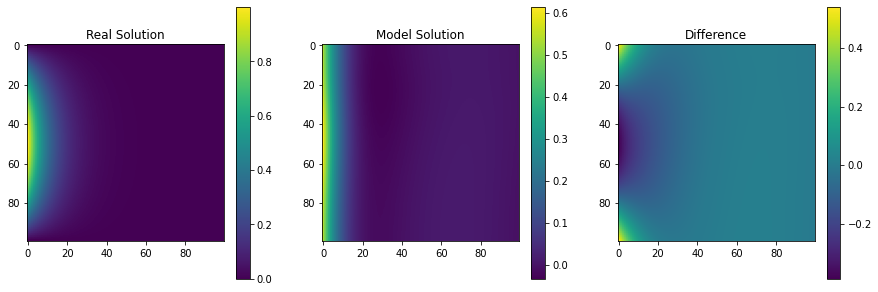

In [6]:
from matplotlib import pyplot as plt
with torch.no_grad():
    real_solution_plot = equation.real_solution(grid_points).cpu().numpy().reshape(resolution,resolution)
    model_solution_plot = model(grid_points).cpu().numpy().reshape(resolution,resolution)
    diff_solution_plot = (model_solution_plot - real_solution_plot)

    fig,ax = plt.subplots(1,3,figsize = (15,5))
    im = ax[0].imshow(real_solution_plot)
    ax[0].set_title("Real Solution")
    fig.colorbar(im, ax=ax[0])
    im = ax[1].imshow(model_solution_plot)
    ax[1].set_title("Model Solution")
    fig.colorbar(im, ax=ax[1])
    im = ax[2].imshow(diff_solution_plot)
    ax[2].set_title("Difference")
    fig.colorbar(im, ax=ax[2])
    plt.show()